In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
class_names = ['armyworm','beetle','cicadellidae','cricket','grasshopper','limacodidae','lycorma_delicatula','mosquito','weevil']

In [3]:
cd drive/MyDrive

/content/drive/MyDrive


In [4]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import os
import glob
import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


In [5]:
image_size = 224
data_path = 'data'

In [6]:
def build_model(image_size=image_size, n_class=3):

    model_vgg16_conv = VGG16(weights=None, include_top=False)

    input = Input(shape=(image_size, image_size, 3), name='image_input')
    output_vgg16_conv = model_vgg16_conv(input)

    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dropout(0.5)(x)
    x = Dense(n_class, activation='softmax', name='predictions')(x)

    # Compile
    my_model = Model(inputs=input, outputs=x)
    my_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])

    return my_model


In [7]:
def load_data(data_path, class_names, image_size):
    data = []
    label = []
    for i_class in class_names:
        read_path = os.path.join(data_path, i_class,"*")
        print(read_path)
        for file in glob.glob(read_path):
            # Read
            print(file)
            image = cv2.imread(file)
            # Resize
            image = cv2.resize(image, dsize=(image_size, image_size))
            # Add to data
            data.append(image)
            label.append(i_class)

    # Encode labels from text to onehot
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(label)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    # Change to numpy array
    label = onehot_encoded
    data = np.array(data)
    return data, label, label_encoder



In [8]:
my_model = build_model(image_size,len(class_names))

In [9]:
from sklearn.model_selection import train_test_split
# Make model
#model = build_model(image_size, len(class_names))

# Load data train from folder
X, y, le = load_data(os.path.join(data_path), class_names, image_size)

# Load data test from folder
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=100)
print(X_train.shape)
print(y_train.shape)

import pickle
file = open('le.pkl', 'wb')
pickle.dump(le, file)
file.close()


Streaming output truncated to the last 5000 lines.
data/armyworm/16952.jpg
data/armyworm/16925.jpg
data/armyworm/16912.jpg
data/armyworm/16932.jpg
data/armyworm/16903.jpg
data/armyworm/16971.jpg
data/armyworm/16850.jpg
data/armyworm/16942.jpg
data/armyworm/16929.jpg
data/armyworm/16843.jpg
data/armyworm/16865.jpg
data/armyworm/16858.jpg
data/armyworm/16832.jpg
data/armyworm/16860.jpg
data/armyworm/16949.jpg
data/armyworm/16954.jpg
data/armyworm/16893.jpg
data/armyworm/16931.jpg
data/armyworm/16897.jpg
data/armyworm/16839.jpg
data/armyworm/17065.jpg
data/armyworm/17063.jpg
data/armyworm/16981.jpg
data/armyworm/17013.jpg
data/armyworm/17046.jpg
data/armyworm/17066.jpg
data/armyworm/16978.jpg
data/armyworm/16990.jpg
data/armyworm/17022.jpg
data/armyworm/17027.jpg
data/armyworm/17015.jpg
data/armyworm/17057.jpg
data/armyworm/17072.jpg
data/armyworm/16983.jpg
data/armyworm/16993.jpg
data/armyworm/17014.jpg
data/armyworm/17031.jpg
data/armyworm/17053.jpg
data/armyworm/17009.jpg
data/armyworm

In [10]:
my_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 fc1 (Dense)                 (None, 4096)              102764544 
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 fc2 (Dense)                 (None, 4096)              16781312  
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0     

In [11]:
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

In [12]:
aug = ImageDataGenerator(
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [13]:
#filepath="weights-{epoch:02d}-{val_accuracy:.2f}.hdf5"
filepath="VGG16-f-w-max.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [14]:
import time
start = time.time()
hist = my_model.fit_generator(aug.flow(X_train, y_train, batch_size = 64), callbacks=callbacks_list, epochs=100, validation_data=aug.flow(X_test, y_test, batch_size = 64), verbose=1)
end = time.time()
print("Training time : ", end - start)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/100
68/68 [==============================] - ETA: 0s - loss: 2.1842 - accuracy: 0.1236
Epoch 1: val_accuracy improved from -inf to 0.14668, saving model to VGG16-f-w-max.hdf5
68/68 [==============================] - 149s 2s/step - loss: 2.1842 - accuracy: 0.1236 - val_loss: 2.1472 - val_accuracy: 0.1467
Epoch 2/100
68/68 [==============================] - ETA: 0s - loss: 2.0723 - accuracy: 0.2124
Epoch 2: val_accuracy improved from 0.14668 to 0.20387, saving model to VGG16-f-w-max.hdf5
68/68 [==============================] - 91s 1s/step - loss: 2.0723 - accuracy: 0.2124 - val_loss: 2.0279 - val_accuracy: 0.2039
Epoch 3/100
68/68 [==============================] - ETA: 0s - loss: 1.9580 - accuracy: 0.2576
Epoch 3: val_accuracy improved from 0.20387 to 0.31181, saving model to VGG16-f-w-max.hdf5
68/68 [==============================] - 97s 1s/step - loss: 1.9580 - accuracy: 0.2576 - val_loss: 1.8608 - val_accuracy: 0.3118
Epoch 4/100
68/68 [==============================] - ETA:

In [15]:
my_model.save("VGG16-f-w-last.hdf5")

In [16]:
import matplotlib.pyplot as plt
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(model_history.history[acc]) + 1), model_history.history[acc])
    axs[0].plot(range(1, len(model_history.history[val_acc]) + 1), model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(model_history.history[acc]) + 1), len(model_history.history[acc]) / 10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss']) / 10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  app.launch_new_instance()


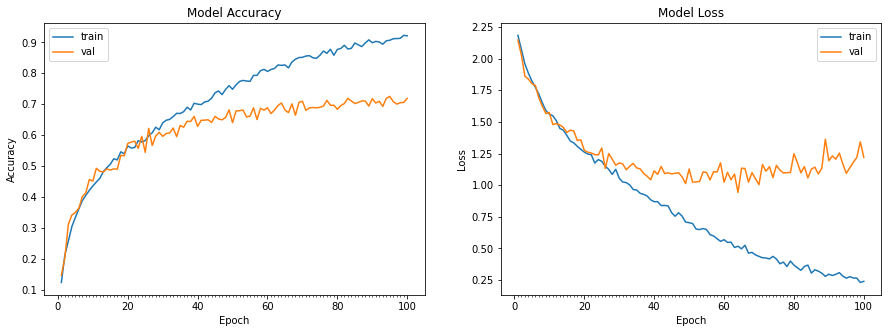

In [17]:
plot_model_history(hist)